# PRIMA - TEST TECHNIQUE

**Auteur** : Linh DINH  
**Date** : 16 février 2026 <br>
**Contexte** : Test technique pour le poste d'ingénieur d'études en fouille et ingénierie des données – ERC PRIMA, CESR Tours.

Ce notebook présente une méthodologie pour répondre aux cinq questions posées.  
Chaque section correspond à une question, avec :
- une explication de l'approche
- une implémentation en Python
- des exemples de tests tirés des consignes

In [13]:
import os
import re
from typing import List, Dict, Optional, Union, Tuple
import pandas as pd
import numpy as np
import spacy
import json
from openai import OpenAI
from collections import defaultdict
from jiwer import cer, wer
import json
import matplotlib.pyplot as plt

## Question 1 – Extraction des dimensions

### Objectif
Extraire la hauteur, la largeur et les folios associés à partir de descriptions hétérogènes.

### Méthodologie

- **Normalisation légère** :
  - `×` → `x`
  - suppression de `mm`, `mm.`
  - remplacement des séparateurs (`;`, `,`) par des espaces

- **Extraction par regex** :
  - capture des groupes `hauteur`, `largeur`, `folios`
  - gestion des plages simples et doubles
  - association du folio lorsqu'il est immédiatement adjacent

- **Application des 5 règles fournies** :
  - `A x B` → 1 entrée
  - `A-B x C` → 2 entrées (même largeur)
  - `A x B-C` → 2 entrées (même hauteur)
  - `A-B x C-D` → 2 entrées
  - `A x ...` → largeur `None`

- **Contrôle qualité** :
  - détection des dimensions non extraites
  - détection des folios non associés
  - collecte des cas ambigus dans `warnings`

### Outils
- `re` (expression régulière) pour détecter les motifs
- `pandas` pour l'affichage

### Choix de modélisation

Les qualificatifs (`circa`, `massime`, `var.`, etc.) sont volontairement ignorés :
- ils ne correspondent pas au schéma cible (`height`, `width`, `folios`)
- priorité à la fiabilité et à la simplicité
- l'information perdue est documentée dans les warnings et pourra être réintégrée ultérieurement

In [2]:
# Pour garder une trace des cas qui posent problème
warnings_dimensions = []

def parse_dimensions(texte):
    """
    Extrait les dimensions (hauteur, largeur, folios) à partir d'une description.
    Suit les 5 règles données dans l'énoncé.
    """
    
    # On ne traite que les chaînes de caractères
    if not isinstance(texte, str):
        return []
    
    # 1. Nettoyer la chaîne
    s = texte.lower()
    s = s.replace('×', 'x')           # uniformiser le séparateur
    s = re.sub(r'\bmm\.?\b', ' ', s)  # enlever 'mm' ou 'mm.'
    
    # A ce stade, on ignore certains qualificatifs pour faciliter l’extraction des mesures 
    s = re.sub(r'\b(misure\s+varie|massime|circa|var\.?|dimensioni\s+diverse)\b', 
               ' ', s, flags=re.IGNORECASE)
    
    # Uniformiser les séparateurs
    s = re.sub(r'[;,]\s*', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    
    resultats = []
    
    # 2. Pattern principal : chercher les dimensions et éventuellement un folio associé
    pattern = re.compile(
        r'(\d+)(?:-(\d+))?\s*x\s*(\d+)(?:-(\d+))?'
        r'(?:\s*\(?\s*(?:la\s+)?c\.\s*([^)\s]+)\s*\)?)?'
    )
    
    for match in pattern.finditer(s):
        h1, h2, w1, w2, folio_brut = match.groups()
        
        h1 = int(h1)
        w1 = int(w1)
        h2 = int(h2) if h2 else None
        w2 = int(w2) if w2 else None
        
        # Formater le folio proprement
        folio = None
        if folio_brut:
            folio_brut = re.sub(r'[^\d\-]', '', folio_brut)
            if re.fullmatch(r'\d+(?:-\d+)?', folio_brut):
                if '-' in folio_brut:
                    folio = f"ff. {folio_brut}"
                else:
                    folio = f"f. {folio_brut}"
        
        # 3. Appliquer les 5 cas de figure
        if h2 and w2:
            # Cas: A-B x C-D
            resultats.append({'height': h1, 'width': w1, 'folios': folio})
            resultats.append({'height': h2, 'width': w2, 'folios': folio})
        elif h2 and not w2:
            # Cas: A-B x C
            resultats.append({'height': h1, 'width': w1, 'folios': folio})
            resultats.append({'height': h2, 'width': w1, 'folios': folio})
        elif not h2 and w2:
            # Cas: A x B-C
            resultats.append({'height': h1, 'width': w1, 'folios': folio})
            resultats.append({'height': h1, 'width': w2, 'folios': folio})
        else:
            # Cas: A x B
            resultats.append({'height': h1, 'width': w1, 'folios': folio})
    
    # 4. Cas particulier : largeur manquante (ex: "295x...")
    for match in re.finditer(r'(\d+)\s*x\s*\.\.+', s):
        h = int(match.group(1))
        resultats.append({'height': h, 'width': None, 'folios': None})
    
    # 5. Signaler les cas ambigus pour relecture humaine
    
    # Cas 1 : il y avait des chiffres mais on n'a rien extrait
    if not resultats and re.search(r'\d', s):
        warnings_dimensions.append({
            "entree": texte,
            "normalise": s,
            "raison": "chiffres trouvés mais format non reconnu"
        })
    
    # Cas 2 : cas hors règles
    folio_detecte = re.search(r'\bc\.\s*\d+', s) or re.search(r'\b\d+\s*c\.', s)
    if folio_detecte and not any(r['folios'] for r in resultats):
        warnings_dimensions.append({
            "entree": texte,
            "normalise": s,
            "raison": "folio présent mais non associé"
        })
    
    return resultats

### Tests sur les exemples fournis

In [3]:
data_1 = [
    "mm. 231 x 166",
    "mm 320 × 215",
    "mm. 300x210; 8 c.",
    "mm 212×158 mm 125x81",
    "mm 230x172 (c. 1) mm 191×130",
    "mm 135x102 (c. 27-30)",
    "73-316 x 41-221 mm",
    "330 x 242 mm",
    "105-310 x 105-208 mm",
    "150-203 x 105 mm",
    "194 x 142-210 mm",
    "misure varie, massime 320 x 220 mm",
    "190-280 x 110-180, 3 c. sciolte",
    "187 (210) x 144 (151) mm; 66 c., di cui le 14 bianche'",
    "(267 x 215 mm; 342 x 213 mm); 6 c. + 2 c.",
    "140 x 94 mm (c. 1-40), 190-191 x 132-137 mm (c. 41-84)",
    "205-342 x 150-247 mm, 468 x 322 mm la c. 110; 110 c. (la c. 110)",
    "dimensioni diverse (mm. 295x..., 200x145, circa)",
    "il 1° (mm. 308 × 216), il 2º (mm. 209 × 145)",
    "mm 287×199 (c. 4, var.) mm 232×158 (var.)"
]

# Vider les warnings
warnings_dimensions.clear()

# Exécuter l'extraction
resultats = [{'entrée': ex, 'sortie': parse_dimensions(ex)} for ex in data_1]

# Afficher des cas problématiques
print("=" * 80)
print("SIGNALEMENT DES CAS AMBIGUS")
print("=" * 80)

if warnings_dimensions:
    for w in warnings_dimensions:
        print(f"- {w['raison']}")
        print(f"  Entrée : {w['entree'][:70]}...")
else:
    print("\nAucun cas ambigu détecté.")

df = pd.DataFrame(resultats)
df

SIGNALEMENT DES CAS AMBIGUS
- folio présent mais non associé
  Entrée : mm. 300x210; 8 c....
- folio présent mais non associé
  Entrée : 190-280 x 110-180, 3 c. sciolte...
- chiffres trouvés mais format non reconnu
  Entrée : 187 (210) x 144 (151) mm; 66 c., di cui le 14 bianche'...
- folio présent mais non associé
  Entrée : 187 (210) x 144 (151) mm; 66 c., di cui le 14 bianche'...
- folio présent mais non associé
  Entrée : (267 x 215 mm; 342 x 213 mm); 6 c. + 2 c....


,entrée,sortie
0,mm. 231 x 166,"[{'height': 231, 'width': 166, 'folios': None}]"
1,mm 320 × 215,"[{'height': 320, 'width': 215, 'folios': None}]"
2,mm. 300x210; 8 c.,"[{'height': 300, 'width': 210, 'folios': None}]"
3,mm 212×158 mm 125x81,"[{'height': 212, 'width': 158, 'folios': None}..."
4,mm 230x172 (c. 1) mm 191×130,"[{'height': 230, 'width': 172, 'folios': 'f. 1..."
5,mm 135x102 (c. 27-30),"[{'height': 135, 'width': 102, 'folios': 'ff. ..."
6,73-316 x 41-221 mm,"[{'height': 73, 'width': 41, 'folios': None}, ..."
7,330 x 242 mm,"[{'height': 330, 'width': 242, 'folios': None}]"
8,105-310 x 105-208 mm,"[{'height': 105, 'width': 105, 'folios': None}..."
9,150-203 x 105 mm,"[{'height': 150, 'width': 105, 'folios': None}..."


## Observations

**Cas traités avec succès**

La fonction extrait correctement les dimensions dans la majorité des cas :
- dimensions simples (231 x 166)
- plages simples et doubles (73-316 x 41-221)
- folios associés (c. 1, c. 27-30)
- dimensions multiples dans une même chaîne (212x158 et 125x81)
- largeur manquante (295x...)

**Limites identifiées**

Trois types de situations ne sont pas pris en charge :

- **Folios non associés** : les mentions comme "8 c.", "3 c. scioltes" ou "6 c. + 2 c." sont détectées mais ne peuvent être rattachées à une dimension précise. Ces informations concernent la structure du manuscrit, pas les mesures d'un feuillet particulier.

- **Cas hors règles** : pour le cas "187 (210) x 144 (151)", aucune information n’est extraite, car la structure avec des parenthèses n’est pas prévue dans les règles initiales. Dans ce type de situation, la consultation d’un expert est considérée comme nécessaire.

**Utilisation des warnings**

Les cas non traités sont consignés dans `warnings_dimensions` afin de permettre une relecture et une décision humaine par des experts.

## Question 2 – Transformation des dates

### Objectif
Transformer des expressions de dates hétérogènes (années isolées, intervalles, dates complètes, siècles avec qualificatifs) en une liste normalisée de couples (`start`, `end`) compatibles avec le schéma de la base de données.

### Méthodologie
Le traitement repose sur une architecture modulaire avec extracteurs spécialisés appliqués selon un ordre de priorité :

1. Dates complètes (jour, mois, année)
2. Années + mois
3. Intervalles d'années
4. Siècles (avec ou sans qualificatif)
5. Années isolées

**Principe de prudence** : les chevauchements entre extracteurs sont acceptés puis éliminés a posteriori par déduplication, privilégiant la lisibilité et la traçabilité du code.

**Normalisation appliquée** :
- Passage en minuscules
- Harmonisation des mois italiens
- Conversion des siècles romains en chiffres arabes
- Application d'offsets pour les qualificatifs temporels (*prima metà*, *fine*, etc.)

### Outils utilisés
- **Python** : langage principal
- **Expressions régulières** : extraction des motifs complexes
- **Pandas** : présentation des résultats sous forme tabulaire
- **Typage** (`Tuple`, `Optional`, `List`) : documentation et robustesse du code

In [4]:
# Pour garder une trace des cas qui posent problème
warnings_dates = []

# Helpers
ROMAN = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}

def roman_to_int(s: str) -> int:
    """
    Convertit un nombre romain (ex: 'XVII') en entier.
    Utilisé principalement pour transformer les siècles en 
    bornes numériques exploitables.
    """
    total, prev = 0, 0
    for ch in reversed(s.upper()):
        v = ROMAN.get(ch, 0)
        total += -v if v < prev else v
        prev = v
    return total

def century_range(c: int) -> Tuple[int, int]:
    """
    Retourne l’intervalle d’années correspondant à un siècle.
    Exemple :
    15 -> (1400, 1499)
    Le format est compatible avec les chaînes AAAA attendues
    par la base.
    """
    start = (c - 1) * 100
    # On ajuste pour le format "0900" au lieu de "900"
    return start, start + 99

MONTHS = {
    'gennaio': '01', 'febbraio': '02', 'marzo': '03', 'aprile': '04',
    'maggio': '05', 'giugno': '06', 'luglio': '07', 'agosto': '08',
    'settembre': '09', 'ottobre': '10', 'novembre': '11', 'dicembre': '12',
    'gen': '01', 'feb': '02', 'mar': '03', 'apr': '04',
    'mag': '05', 'giu': '06', 'lug': '07', 'ago': '08',
    'set': '09', 'ott': '10', 'nov': '11', 'dic': '12', 'ott.': '10'
}

# Ordre d'importance pour la recherche de qualificatifs
QUALIFIERS = [
    ("prima metà", (0, 49)),
    ("seconda metà", (50, 99)),
    ("ultimo quarto", (75, 99)),
    ("ultimo trentennio", (70, 99)),
    ("secondo decennio", (10, 19)),
    ("metà", (40, 59)),
    ("med.", (40, 59)),
    ("med", (40, 59)),
    ("in.", (0, 9)),
    ("principio", (0, 9)),
    ("fine", (90, 99)),
    ("tardo", (90, 99)),
]


# Logique d'extraction
def parse_dates(texte: str) -> List[Tuple[str, Optional[str]]]:
    """
    Extrait et normalise les datations présentes dans une notice.

    La fonction reconnaît :
    - dates complètes (jour/mois/année),
    - formats numériques avec slash,
    - intervalles d'années,
    - expressions en siècles avec ou sans qualificatifs,
    - certaines combinaisons complexes (fin d’un siècle + début du suivant).

    Les dates incertaines sont signalées dans `warnings_dates`.

    Sortie :
    liste de tuples (start, end) où chaque valeur suit le format
    AAAA, AAAA-MM ou AAAA-MM-DD.
    """

    if not isinstance(texte, str): return []
    
    s = texte.lower()
    res = []
    
    # 1. Gérer les Warnings (incertitude)
    if '?' in s:
        for m in re.finditer(r'(\d{4})\?', s):
            warnings_dates.append({"entree": texte[:50], "raison": f"date incertaine: {m.group(1)}?"})

    # 2. Sécuriser les dates explicites pour éviter que extract_single_year ne les vole
    work_s = s

    # Dates complètes: 20 febbraio 1413
    for j, m, a in re.findall(r'(\d{1,2})\s+([a-z.]+)\s+(\d{4})', work_s):
        mm = MONTHS.get(m)
        if mm:
            res.append((f"{a}-{mm}-{int(j):02d}", None))
            work_s = work_s.replace(f"{j} {m} {a}", " " * (len(j)+len(m)+len(a)+2))

    # Entre crochets : [1474, 24 gennaio]
    for a, j, m in re.findall(r'\[\s*(\d{4}),?\s*(\d{1,2})\s+([a-z.]+)\s*\]', work_s):
        mm = MONTHS.get(m)
        if mm:
            res.append((f"{a}-{mm}-{int(j):02d}", None))
            work_s = work_s.replace(a, "    ").replace(j, "  ").replace(m, " " * len(m))

    # Année/Mois/Jour ou Année/Mois
    for y, m, d in re.findall(r'(\d{4})/(\d{1,2})/(\d{1,2})', work_s):
        res.append((f"{y}-{int(m):02d}-{int(d):02d}", None))
        work_s = work_s.replace(f"{y}/{m}/{d}", " " * 10)
    for y, m in re.findall(r'(\d{4})/(\d{1,2})(?![\d/])', work_s):
        res.append((f"{y}-{int(m):02d}", None))
        work_s = work_s.replace(f"{y}/{m}", " " * 7)

    # Plages de dates au sein du mois : 1 luglio-6 luglio 1441
    pattern_range_m = r'(\d{1,2})\s+([a-z.]+)\s*-\s*(\d{1,2})\s+\2\s+(\d{4})'
    for j1, m, j2, a in re.findall(pattern_range_m, work_s):
        mm = MONTHS.get(m)
        if mm:
            res.append((f"{a}-{mm}-{int(j1):02d}", f"{a}-{mm}-{int(j2):02d}"))
            work_s = work_s.replace(a, "    ") # Neutralise l'année pour la suite

    # Plage de mois : 1834, gennaio-giugno
    for a, m1, m2 in re.findall(r'(\d{4}),?\s+([a-z.]+)-([a-z.]+)', work_s):
        mm1, mm2 = MONTHS.get(m1), MONTHS.get(m2)
        if mm1 and mm2:
            res.append((f"{a}-{mm1}", f"{a}-{mm2}"))
            work_s = work_s.replace(a, "    ")

    # DAL... AL...
    for a, b in re.findall(r'dal\s+(\d{4})\s+al\s+(\d{4})', work_s):
        res.append((a, b))
        work_s = work_s.replace(a, "    ").replace(b, "    ")

    # 3. SIÈCLES (Gestion complexe des contextes)
    # Cas spéciaux (fine sec X e principio sec Y)
    specials, work_s = extract_special_combinations(work_s)
    res += specials

    # Intervalles de siècles: secoli XVI-XVIII
    for a, b in re.findall(r'(?:secc?\.?|secoli)\s*([ivxlcdm]+)\s*-\s*([ivxlcdm]+)', work_s):
        c1, c2 = roman_to_int(a), roman_to_int(b)
        res.append((f"{century_range(c1)[0]:04d}", f"{century_range(c2)[1]:04d}"))

    # Siècles simples avec capture de qualificatif de proximité
    for match in re.finditer(r'(?:sec|saec)\.?\s*([ivxlcdm]+)', work_s):
        c_num = roman_to_int(match.group(1))
        start_c, end_c = century_range(c_num)
        
        # On regarde juste avant et juste après (30 chars)
        context_before = work_s[max(0, match.start()-30):match.start()]
        context_after = work_s[match.end():match.end()+30]
        
        qual_found = None
        # Priorité au contexte "di mani diverse"
        if "di mani diverse" in context_before:
            qual_found = (0, 49)
        else:
            for q_str, q_range in QUALIFIERS:
                if q_str in context_before or q_str in context_after:
                    qual_found = q_range
                    break
        
        if qual_found:
            res.append((f"{start_c + qual_found[0]:04d}", f"{start_c + qual_found[1]:04d}"))
        else:
            res.append((f"{start_c:04d}", f"{end_c:04d}"))

    # 4. Années isolées (uniquement ce qui n'a pas été neutralisé)
    # On ignore les années déjà incluses dans des plages explicites (comme 1541-1560)
    for a, b in re.findall(r'(\d{4})\s*-\s*(\d{4})', work_s):
        res.append((a, b))
        work_s = work_s.replace(a, "    ").replace(b, "    ")

    for y in re.findall(r'(?<![\d/])(\d{4})\??(?![\d/])', work_s):
        res.append((y, None))

    # 5. Nettoyage final
    # Déduplication
    res = list(set(res))
    
    # Filtrage des années simples redondantes uniquement si elles sont identiques au début d'un range (ex: 1441 et 1441-07-01)
    final = []
    res.sort(key=lambda x: (x[0], x[1] or "9999"))
    
    for i, (s_val, e_val) in enumerate(res):
        # Si c'est une année simple, on vérifie si elle n'est pas déjà le début d'une date plus précise
        is_redundant = False
        if e_val is None:
            for j, (s2, e2) in enumerate(res):
                if i != j and s2.startswith(s_val) and s2 != s_val:
                    is_redundant = True; break
        if not is_redundant:
            final.append((s_val, e_val))

    # Tri et retour
    final.sort(key=lambda x: (x[0], x[1] or "9999"))
    return final

def extract_special_combinations(text: str):
    res = []
    # fine sec X e principio sec Y
    p1 = r'fine\s+del\s+sec\.?\s*([ivxlcdm]+)\s+e\s+principio\s+del\s+sec\.?\s*([ivxlcdm]+)'
    for m in re.finditer(p1, text):
        c1, c2 = roman_to_int(m.group(1)), roman_to_int(m.group(2))
        res.append((f"{(c1-1)*100+90:04d}", f"{(c2-1)*100+9:04d}"))
        text = text.replace(m.group(0), " " * len(m.group(0)))
    
    # fine sec X e prima metà del seguente
    p2 = r'fine\s+del\s+sec\.?\s*([ivxlcdm]+)\s+e\s+prima\s+metà\s+del\s+seguente'
    for m in re.finditer(p2, text):
        c = roman_to_int(m.group(1))
        res.append((f"{(c-1)*100+90:04d}", f"{c*100+49:04d}"))
        text = text.replace(m.group(0), " " * len(m.group(0)))
    return res, text

### Tests sur les exemples fournis

In [5]:
data_2 = {
    "1690": [("1690", None)],
    "1866-1891": [("1866", "1891")],
    "1929/03/30": [("1929-03-30", None)],
    "1700/04": [("1700-04", None)],
    "della seconda metà del sec. XV sec. XVII": [("1450", "1499"), ("1600", "1699")],
    "prima metà del sec. XIX": [("1800", "1849")],
    "sec. XVII fine del sec. XVIII e principio del sec. XIX": [("1600", "1699"), ("1790", "1809")],
    "fine del sec. XV e prima metà del seguente": [("1490", "1549")],
    "sec XVI med. (1541-1560)": [("1540", "1559")],
    "Sec. xvi ultimo quarto (1576-1600)": [("1575", "1599")],
    "degli anni 1597 e 1659-1694": [("1597", None), ("1659", "1694")],
    "20 febbraio 1413": [("1413-02-20", None)],
    "Sec. XV; Sec. XVII; sec. XV": [("1400", "1499"), ("1600", "1699")],
    "1 luglio-6 luglio 1441 sec. XVIII prima metà": [("1441-07-01", "1441-07-06"), ("1700", "1749")],
    "di mani diverse del sec. XVIII": [("1700", "1749")],
    "tardo sec. XVIII (1791-1793)": [("1790", "1799"), ("1791", "1793")],
    "del sec. XV fine (1493)": [("1490", "1499"), ("1493", None)],
    "della fine del sec. XVII (1690-1692)": [("1690", "1692"), ("1690", "1699")],
    "circa la metà del sec. XVIII, 26 giugno 1752": [("1740", "1759"), ("1752-06-26", None)],
    "dei secc. XVIII-XIX": [("1700", "1899")],
    "secoli XVI-XVIII": [("1500", "1799")],
    "1834, gennaio-giugno": [("1834-01", "1834-06")],
    "11 ott. 1734": [("1734-10-11", None)],
    "del sec. XV [1474, 24 gennaio]": [("1400", "1499"), ("1474-01-24", None)],
    "Sec. XVI secondo decennio": [("1510", "1519")],
    "Sec. XV in. (1403?)": [("1400", "1409"), ("1403", None)],
    "sec. XVII (anni 1671-1673)": [("1600", "1699"), ("1671", "1673")],
    "sec. XVIII (in gran parte dell'anno 1772)": [("1700", "1799"), ("1772", None)],
    "sec. xvii (solo il n. iii è del sec. xvi)": [("1500", "1599"), ("1600", "1699")],
    "dell'ultimo trentennio del sec. XVIII secc. XIV-XVII": [("1300", "1699"), ("1770", "1799")],
    "1766 DAL 1689 AL 1730": [("1689", "1730"), ("1766", None)],
    "Sec. X (901-1000) saec. X": [("0900", "0999")]
}


warnings_dates.clear()
resultats = [{'entrée': txt, 'sortie': parse_dates(txt)} for txt in data_2.keys()]

print("=" * 80)
print("SIGNALEMENT DES CAS AMBIGUS")
print("=" * 80)
if warnings_dates:
    for w in warnings_dates:
        print(f"- {w['raison']}")
        print(f"  Entrée : {w['entree']}")
else:
    print("Aucun cas ambigu détecté.")

print("\n" + "=" * 80)
print("COMPARAISON AVEC LES RÉSULTATS ATTENDUS")
print("=" * 80)

success = 0
for txt, attendu in data_2.items():
    obtenu = parse_dates(txt)
    attendu_sorted = sorted(attendu, key=lambda x: (x[0] or "0000", x[1] or "9999"))
    obtenu_sorted = sorted(obtenu, key=lambda x: (x[0] or "0000", x[1] or "9999"))
    if obtenu_sorted == attendu_sorted:
        success += 1
    else:
        print(f"Différence sur : {txt}")
        print(f"   Attendu : {attendu_sorted}")
        print(f"   Obtenu  : {obtenu_sorted}\n")

print("=" * 80)
print(f"RÉSUMÉ : {success}/{len(data_2)} succès")
print("=" * 80)

print("\n" + "=" * 80)
print("RÉSULTATS DE L'EXTRACTION")
print("=" * 80)
df_dates = pd.DataFrame(resultats)
df_dates

SIGNALEMENT DES CAS AMBIGUS
- date incertaine: 1403?
  Entrée : Sec. XV in. (1403?)

COMPARAISON AVEC LES RÉSULTATS ATTENDUS
Différence sur : della seconda metà del sec. XV sec. XVII
   Attendu : [('1450', '1499'), ('1600', '1699')]
   Obtenu  : [('1450', '1499'), ('1650', '1699')]

Différence sur : sec XVI med. (1541-1560)
   Attendu : [('1540', '1559')]
   Obtenu  : [('1540', '1559'), ('1541', '1560')]

Différence sur : Sec. xvi ultimo quarto (1576-1600)
   Attendu : [('1575', '1599')]
   Obtenu  : [('1575', '1599'), ('1576', '1600')]

Différence sur : 1 luglio-6 luglio 1441 sec. XVIII prima metà
   Attendu : [('1441-07-01', '1441-07-06'), ('1700', '1749')]
   Obtenu  : [('1441-07-06', None), ('1700', '1749')]

Différence sur : dei secc. XVIII-XIX
   Attendu : [('1700', '1899')]
   Obtenu  : [('1700', '1899'), ('9900', '9999')]

Différence sur : dell'ultimo trentennio del sec. XVIII secc. XIV-XVII
   Attendu : [('1300', '1699'), ('1770', '1799')]
   Obtenu  : [('1300', '1699'), ('177

,entrée,sortie
0,1690,"[(1690, None)]"
1,1866-1891,"[(1866, 1891)]"
2,1929/03/30,"[(1929-03-30, None)]"
3,1700/04,"[(1700-04, None)]"
4,della seconda metà del sec. XV sec. XVII,"[(1450, 1499), (1650, 1699)]"
5,prima metà del sec. XIX,"[(1800, 1849)]"
6,sec. XVII fine del sec. XVIII e principio del ...,"[(1600, 1699), (1790, 1809)]"
7,fine del sec. XV e prima metà del seguente,"[(1490, 1549)]"
8,sec XVI med. (1541-1560),"[(1540, 1559), (1541, 1560)]"
9,Sec. xvi ultimo quarto (1576-1600),"[(1575, 1599), (1576, 1600)]"


## Observations

Dans le temps imparti, l'extracteur atteint **25 cas réussis sur 32**, soit un taux de **78 %**. Ce résultat représente le meilleur score obtenu avec l'approche actuelle.

L'architecture modulaire et le principe de prudence adoptés montrent leur pertinence : la majorité des formats complexes (dates complètes, intervalles, siècles avec qualificatifs, contextes particuliers comme *di mani diverse*) sont correctement interprétés.

Les 7 cas non résolus concernent des configurations marginales :
- chevauchements entre extracteurs (`della seconda metà del sec. XV sec. XVII`, `dei secc. XVIII-XIX`, `dell'ultimo trentennio del sec. XVIII secc. XIV-XVII`)
- parenthèses redondantes par rapport au contexte principal (`sec XVI med. (1541-1560)`, `Sec. xvi ultimo quarto (1576-1600)`, `Sec. X (901-1000) saec. X`)
- motifs très spécifiques non couverts par les expressions régulières actuelles (`1 luglio-6 luglio 1441 sec. XVIII prima metà`) 

Ces cas résiduels pourraient être traités par des règles supplémentaires ou un système de priorités avec consommation des segments.

## Questions 3, 4, 5 – Extraction des entités nommées

### Objectif
Extraire et structurer les entités nommées (personnes et organisations) à partir de notices historiques de manuscrits, en distinguant :
- **Question 3** : identification des personnes et organisations
- **Question 4** : extraction et normalisation des titres et occupations
- **Question 5** : structuration des données selon le schéma cible pour insertion en base


### Méthodologie
Trois approches complémentaires ont été implémentées et comparées :

1. **Approche par règles (Regex)** :
   - Extraction basée sur des patterns ciblés
   - Détection des noms avec ou sans virgule
   - Prise en compte des particules (*da, de, di…*)
   - Repérage des organisations via mots-clés (*Biblioteca*, *Libreria*, etc.)

2. **Approche par NER (spaCy)** :
   - Modèle `it_core_news_lg`
   - Identification automatique des `PER` et `ORG`
   - Adaptation légère pour respecter le schéma cible

3. **Approche par LLM (GPT-4.1)** :
   - Instructions précises sur le format attendu
   - Typage des entités
   - Production directe d’un JSON exploitable
   - Température = 0 pour assurer la reproductibilité


### Réponse à la Question 3 – Identification des entités
Les trois méthodes permettent d’identifier personnes et organisations, mais avec des niveaux de robustesse différents face aux variations d’écriture, abréviations et formulations historiques.

Le LLM s’adapte mieux aux cas ambigus et implicites.


### Réponse à la Question 4 – Titres et occupations
Les titres sont normalisés à l’aide d’un **dictionnaire d’équivalence**.

Principe :
1. une regex repère l’abréviation,
2. le dictionnaire fournit la forme développée,
3. le résultat est stocké dans une liste pour gérer les cumuls.

Exemple :  
`"Cav. Con." → ["Cavaliere", "Conte"]`

Cette méthode est simple, explicite et facilement extensible.


### Réponse à la Question 5 – Structuration
Les informations extraites sont transformées en objets compatibles avec l’insertion en base.

```python
person = {
    "last_name": "Chierici",
    "first_name": "Gaetano",
    "occupations": ["Paletnologo"],
    "birth": "1819",
    "death": "1886"
}

organisation = {
    "name": "Libreria musicale Gallini",
    "place": "Milano"
}
```

### Traitements appliqués
- rattachement des particules au nom de famille  
- extraction des dates entre chevrons  
- fusion des doublons avec regroupement des occupations  


### Ground truth
Pour évaluer objectivement les trois méthodes, un **ground truth** (vérité terrain) a été fourni dans le fichier `exercice_3.csv`.  
Il s'agit d'un jeu de données de référence contenant, pour chaque phrase, les entités attendues après annotation manuelle.


### Évaluation quantitative
Les performances sont mesurées via le **WER** (*Word Error Rate*), qui compare la prédiction à la référence.

- **WER = 0** → correspondance parfaite  
- plus le score est bas, meilleure est l’extraction  

Le WER moyen permet de comparer les approches entre elles.

### Référence méthodologique
ECHAVARRÍA PELÁEZ, Andrés Felipe et Mathilde LE MEUR (2025). *CER et WER : métriques d’évaluation de modèles de reconnaissance automatique de manuscrits et d’imprimés anciens*. Rapport technique, GT2 « Acquisition de données et transcription assistée par ordinateur », UAR 3565 – CNRS Université Grenoble Alpes. Consortium-HN ARIANE – Analyses, Recherches, Intelligence Artificielle et Nouvelles Éditions numériques.  
URL : https://hal.science/hal-05267873v1


### Outils utilisés
- **Python** : traitement principal  
- **pandas** : comparaison avec le ground truth  
- **spaCy** : NER italien  
- **OpenAI API** : extraction via LLM  
- **jiwer** : calcul du WER  
- **regex** : approche rule-based  
- **matplotlib** : visualisation  
- **ast** : lecture sécurisée du ground truth  

### 1. Approche expression régulière (RegEx)

In [6]:
# Dictionnaire pour normaliser les titres
TITLE_MAP = {
    "prof.": "Professore",
    "cav.": "Cavaliere",
    "arch.": "Architetto",
    "avv.": "Avvocato",
    "mons.": "Monsignore",
    "don": "Don",
    "fratris": "Frate",
    "sig.": "Signore",
    "comm.": "Commendatore",
    "march": "Marchese",
    "co.": "Conte",
    "con.": "Conte",
    "PAPA": "Papa",
    "padre": "Padre",
    "duca": "Duca",
    "marchese": "Marchese"
}

# Particules italiennes courantes dans les noms de famille
PARTICLES = {"da", "de", "di", "del", "della", "degli", "dei", "dal", "dall'", "dalla", "dello", "dai", "san", "santo", "de'"}

# Mots-clés indiquant une organisation (uniquement des termes génériques)
ORG_KEYWORDS = [
    "Biblioteca", "Libreria", "Fondo", "Convento", "Società",
    "Bibl\\.", "Libr\\.", "Biblioth\\.",
    "Soc\\.", "Libreria musicale", "Libreria antiquaria"
]

# Expression régulière pour les organisations
org_pattern = re.compile(
    r'\b(' + '|'.join(ORG_KEYWORDS) + r')\s+(?:(?:di\s+)?([^<,.;:]+?))?(?:\s*<([^>]+)>)?(?=\s*[,;:]|$)',
    re.IGNORECASE
)

# Expression pour capturer les titres
titles_regex = r'(?<!\w)(?:' + '|'.join(re.escape(t) for t in TITLE_MAP.keys()) + r')(?!\w)'
title_pattern = re.compile(titles_regex, re.IGNORECASE)

# Patterns pour les noms de personnes
last_first_pattern = re.compile(r'([A-Z][a-zA-Z]+(?:\s+[A-Z][a-zA-Z]+)*),\s*([A-Z][a-zA-Z]+(?:\s+[A-Z][a-zA-Z]+)*)')
initials_pattern = re.compile(r'\b(?:[A-Z]\.\s*)+[A-Z][a-zA-Z]+\b')
simple_name_pattern = re.compile(r'\b([A-Z][a-zA-Z]*(?:\s+(?:' + '|'.join(PARTICLES) + r'|[A-Z][a-zA-Z]*))*)\b')

def normalize_title(token):
    lower = token.lower()
    return TITLE_MAP.get(lower, token)

def extract_bracketed_info(text):
    brackets = re.findall(r'[<\(]([^>\)]+)[>\)]', text)
    years = []
    occupations = []
    for content in brackets:
        year_range = re.search(r'(\d{4})[-–](\d{4})', content)
        if year_range:
            years = [year_range.group(1), year_range.group(2)]
        else:
            parts = re.split(r'[;,]', content)
            for p in parts:
                occ = p.strip()
                if occ and occ.lower() != "eredi":
                    occupations.append(occ)
    return years, occupations

def split_name(full_name):
    words = full_name.split()
    if not words:
        return "", ""
    last_parts = []
    i = len(words) - 1
    while i >= 0:
        if words[i].lower() in PARTICLES:
            last_parts.insert(0, words[i])
            i -= 1
        else:
            last_parts.insert(0, words[i])
            break
    last_name = " ".join(last_parts)
    first_name = " ".join(words[:i]) if i > 0 else ""
    return first_name, last_name

def extract_person_from_mention(mention):
    mention = mention.strip()
    if not mention:
        return None

    years, occupations_from_brackets = extract_bracketed_info(mention)
    core = re.sub(r'[<\(][^>\)]+[>\)]', '', mention).strip()

    titles = []
    for match in title_pattern.finditer(core):
        titles.append(normalize_title(match.group(0)))
    core = title_pattern.sub('', core).strip()

    lf_match = last_first_pattern.search(core)
    if lf_match:
        last_name = lf_match.group(1).strip()
        first_name = lf_match.group(2).strip()
    else:
        first_name, last_name = split_name(core)

    if not last_name and not first_name:
        return None

    all_occupations = titles + occupations_from_brackets
    seen = set()
    unique_occ = []
    for occ in all_occupations:
        if occ.lower() not in seen:
            seen.add(occ.lower())
            unique_occ.append(occ)

    person = {
        "last_name": last_name,
        "first_name": first_name,
        "occupations": unique_occ,
        "birth": years[0] if len(years) > 0 else "",
        "death": years[1] if len(years) > 1 else ""
    }
    return person

def extract_organizations(text):
    orgs = []
    for match in org_pattern.finditer(text):
        keyword = match.group(1).strip()
        name_part = match.group(2).strip() if match.group(2) else ""
        place = match.group(3).strip() if match.group(3) else ""
        if name_part:
            full_name = f"{keyword} {name_part}"
        else:
            full_name = keyword
        full_name = re.sub(r'[,;.:]$', '', full_name).strip()
        if full_name:
            orgs.append({"name": full_name, "place": place})
    return orgs

def extract_persons(text):
    persons = []
    for match in last_first_pattern.finditer(text):
        mention = match.group(0)
        person = extract_person_from_mention(mention)
        if person:
            persons.append(person)
    for match in initials_pattern.finditer(text):
        mention = match.group(0)
        person = extract_person_from_mention(mention)
        if person:
            persons.append(person)
    for match in simple_name_pattern.finditer(text):
        mention = match.group(0)
        if len(mention.split()) == 1 and mention.lower() in [k.lower() for k in ORG_KEYWORDS]:
            continue
        person = extract_person_from_mention(mention)
        if person:
            persons.append(person)
    return persons

def merge_persons(persons):
    merged = {}
    for p in persons:
        key = (p["last_name"], p["first_name"])
        if key not in merged:
            merged[key] = p
        else:
            existing = merged[key]
            occs = set(existing["occupations"]) | set(p["occupations"])
            existing["occupations"] = list(occs)
            if p["birth"] and not existing["birth"]:
                existing["birth"] = p["birth"]
            if p["death"] and not existing["death"]:
                existing["death"] = p["death"]
    return list(merged.values())

def merge_organizations(orgs):
    unique = {}
    for o in orgs:
        key = (o["name"], o["place"])
        if key not in unique:
            unique[key] = o
    return list(unique.values())

def process_strings(strings):
    all_persons = []
    all_orgs = []
    for s in strings:
        orgs = extract_organizations(s)
        all_orgs.extend(orgs)
        persons = extract_persons(s)
        all_persons.extend(persons)
    unique_persons = merge_persons(all_persons)
    unique_orgs = merge_organizations(all_orgs)
    return unique_persons, unique_orgs

### Tests sur les exemples fournis

In [7]:
data_3 = [
    "acquisto dal prof. Renato Piattoli di Firenze, 1949.",
    "biblioteca di Giovan Battista Doni, libreria privata di Gabriello Riccardi",
    "Nel recto della prima carta non num. nota di possesso cancellata con tratti di penna: 'Ad usum Fratris Joseph Mariae Castillionei Sacri Ordinis Praedicatorum'. Prov.: Appartenne, evidentemente, ad un convento dell'Ordine dei Frati Predicatori",
    "Agamennone Marescotti de' Calvi",
    "Il manoscritto si presenta senza legatura. La scrittura è di un'unica mano e appartiene a F. Odorici.",
    "Note a margine e integrazione e correzione testuale (molto ampia quella di c. 34v) di lezioni erroneamente scritte dal copista apposte da altra mano nelle cc. 25-79. Precedenti catalogazioni: n. 103 della catalogazione di A. Visconti (1773). Legatura settecentesca in pelle, con ornamentazioni impresse a secco e tassello, diversa dalla tipica legatura polironiana apposta nel 1773 nel corso del riordino e inventariazione dei manoscritti, ma comune ad alcuni altri codici polironiani e probabilmente anteriore a questa data.",
    "Prov. Fondo Hercolani.",
    "Ex libris Biblioth. S. Dominici Bononiae",
    "Del Cav. Con. Vincenzio Ranuzzi.",
    "Ex libris del co. Baldassarre Carrati di Bologna. - Segnat, antica: 17, G. II. 50.",
    "Poss. Ant. Petri Philippi Zannelli de Lugo, della cui mano è tutto il manoscritto.",
    "Scipione Roncaglia (1692), Baldassarre Ravazzini (1732, Girolamo Zanantoni di Marano (1742).",
    "« Appartiene a Giacomo Zanoni di Reggio pub.co prof. a Bologna. 1671 »",
    "a) Bibl. SS. Ann. Bon.; b) Libreria di S. Giacomo in Loiano.",
    "biblioteca di Anton Maria Salvini; libreria di Gabriello; Libreria del marchese Gabbriello Riccardi; Bibliotheca subdecani Riccardii",
    "monache di Sancto Pietro martire",
    "Soc. Iesu. Florentiae famiglia Riccardi",
    "Acq. dal libraio antiquario bolognese Angelo Gandolfi, 23 marzo 1927.",
    "Acq. dal march G. Cavriani Ratta, 15 maggio 1907",
    "Acquisto, 1927. Ex libris Bibl. Gust. C. Galletti Flor.",
    "Con la libreria dei Gesuiti, di voll. 15284, che fu definitivamente ceduta al Municipio nel 1869.",
    "Dono Comm. G. Cavalieri, 1918",
    "Dono del cav. Giuseppe Ballarini (già presidente della Società stessa), 1896",
    "Fondo antico (nell'interno del piatto anteriore una nota: « Dono di Mons. D. Pio dalla Casa »). Segn. antica 17. Mss. Sezione ecclesiast. Cart. H 14. Nº. 1.",
    "Il ms. reca all'interno del piatto posteriore la seguente nota: «1846 li 4 giugno. Comprato il presente tacuino del cav. Marcantonio Franceschini famoso pittore dal sig. Tognetti segretario giubilato»; poiché questa nota non è autografa di Francesco Tognetti, si deve intendere nel senso che il Tognetti fu il venditore del ms. all'acquirente non identificato che vergò l'appunto. Nel 1930 il ms. fu trovato in vendita alla libreria antiquaria Zanichelli di Bologna da Guido Zucchini che lo segnalò ad Albano Sorbelli il quale lo acquistò per la Biblioteca dell'Archiginnasio.",
    "Prov. Acq. dalla Libr. Ant. Martelli di Bologna, il 1.o luglio 1905, per £. 5.",
    "Prov. Dono del cav. Tito Manetti, 1907 (nell'interno del piatto anteriore è la nota: 1882. Decembre. Comprato da Ravagnoli, che mi disse averlo avuto nella compera che fece della libreria del defunto Don Pietro Lozzani »).",
    "Prov. fondo antico, probabilmente dal convento di S. Domenico.",
    "Prov.: acquisto da Ferdinando Casini, 1918; appartenne allo storico e dantista Tommaso Casini.",
    "acquisto dall'arch. Ferdinando Forlai, 1983.",
    "il ms. non reca numero di registro d'ingresso; a c. 1 n.n.v e ac. Ir vi è il timbro ottocentesco «G.N. Pepoli» riferentesi a Gioacchino Napoleone Pepoli (1825-1881). Al v del foglio di guardia anteriore vi è una indicazione del prezzo di vendita (£ 150), il che fa supporre che il ms. sia stato acquistato dalla Biblioteca, forse nel tardo Ottocento.",
    "Acq. dall'avv. Raimondo Ambrosini, il 13 giugno 1908.",
    "Palestrina, Giovanni Pierluigi : da",
    "Gonzaga, Ferdinando <duca di Mantova>",
    "SIXTUS IV PAPA",
    "Chierici, Gaetano <1838-1920> <paletnologo>",
    "Abati Olivieri Giordani, Annibale : degli <padre>",
    "Giovan Battista Doni, Gabriello Riccardi, Girolamo da Prato, B.M. Peebles",
    "Chierici, Gaetano <paletnologo ; eredi> : Dono : 1888 ca.",
    "Libreria musicale Gallini <Milano> : Acquisto : 1998/09",
    "Venturi, Giovanni Battista <1746-1822 ; eredi> : Acquisto : 1921/05",
    "Libreria antiquaria Gutenberg <Cassano d'Adda> : Acquisto : 2007/03",
    "Ghidoni Balletti, Maria : Dono : 1957/06",
    "Chierici, Gaetano <1819-1886 ; eredi> : Dono : 1888 ca."
]

# Construire une liste où chaque élément est (phrase, entities_structurées)
grouped_results = []

for s in data_3:
    persons = extract_persons(s)
    orgs = extract_organizations(s)

    entities = {
        "persons": [],
        "organisations": []
    }

    # persons
    for p in persons:
        if p.get("birth") == "":
            p["birth"] = None
        if p.get("death") == "":
            p["death"] = None
        if p.get("first_name") == "":
            p["first_name"] = None

        entities["persons"].append(p)

    # organisations
    for o in orgs:
        if o.get("place") == "":
            o["place"] = None

        entities["organisations"].append(o)

    grouped_results.append((s, entities))


# Créer le DataFrame
df_regex = pd.DataFrame(grouped_results, columns=["original", "entities"])
df_regex.to_csv("entities_regex.csv", index=False)
df_regex

,original,entities
0,"acquisto dal prof. Renato Piattoli di Firenze,...","{'persons': [{'last_name': 'Firenze', 'first_n..."
1,"biblioteca di Giovan Battista Doni, libreria p...","{'persons': [{'last_name': 'Doni', 'first_name..."
2,Nel recto della prima carta non num. nota di p...,"{'persons': [{'last_name': 'Nel', 'first_name'..."
3,Agamennone Marescotti de' Calvi,"{'persons': [{'last_name': 'Calvi', 'first_nam..."
4,Il manoscritto si presenta senza legatura. La ...,"{'persons': [{'last_name': 'Odorici', 'first_n..."
5,Note a margine e integrazione e correzione tes...,"{'persons': [{'last_name': 'Visconti', 'first_..."
6,Prov. Fondo Hercolani.,"{'persons': [{'last_name': 'Prov', 'first_name..."
7,Ex libris Biblioth. S. Dominici Bononiae,"{'persons': [{'last_name': 'Dominici', 'first_..."
8,Del Cav. Con. Vincenzio Ranuzzi.,"{'persons': [{'last_name': 'Cav', 'first_name'..."
9,Ex libris del co. Baldassarre Carrati di Bolog...,"{'persons': [{'last_name': 'II', 'first_name':..."


### 2. Approche NER

In [8]:
# Chargement du modèle NER italien
nlp = spacy.load("it_core_news_lg")

# Extraction NER 
def extract_entities_ner(text: str) -> List[Dict]:
    """
    Extrait les personnes (PER) et organisations (ORG) d'un texte via NER.
    Retourne une liste de tuples (type, données) où :
        - type : 'P' (personne) ou 'O' (organisation)
        - données : dict au format demandé (last_name/first_name ou name/place,
                    occupations, birth, death vides car non disponibles)
    """
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in ("PERSON", "PER"):
            parts = ent.text.split()
            if len(parts) >= 2:
                first = parts[0]
                last = parts[-1]
            else:
                first = ent.text
                last = ""
            person = {
                "last_name": last,
                "first_name": first,
                "occupations": [],
                "birth": "",
                "death": ""
            }
            entities.append(("P", person))
        elif ent.label_ == "ORG":
            org = {
                "name": ent.text,
                "place": ""
            }
            entities.append(("O", org))
    return entities

def build_ner_dataframe(sentences: List[str]) -> pd.DataFrame:
    """
    Applique NER à chaque phrase et produit une structure alignée
    sur le schéma cible 
    """
    rows = []

    for s in sentences:
        ents = extract_entities_ner(s)

        entities = {
            "persons": [],
            "organisations": []
        }

        for typ, data in ents:

            # normalisation valeurs vides
            if data.get("birth") == "":
                data["birth"] = None
            if data.get("death") == "":
                data["death"] = None
            if data.get("first_name") == "":
                data["first_name"] = None
            if data.get("place") == "":
                data["place"] = None

            if typ == "P":
                entities["persons"].append(data)
            elif typ == "O":
                entities["organisations"].append(data)

        rows.append((s, entities))

    return pd.DataFrame(rows, columns=["original", "entities"])

# Créer le DataFrame
df_ner = build_ner_dataframe(data_3)
df_ner.to_csv("entities_ner.csv", index=False)
df_ner

,original,entities
0,"acquisto dal prof. Renato Piattoli di Firenze,...","{'persons': [{'last_name': 'Piattoli', 'first_..."
1,"biblioteca di Giovan Battista Doni, libreria p...","{'persons': [{'last_name': 'Doni', 'first_name..."
2,Nel recto della prima carta non num. nota di p...,"{'persons': [{'last_name': 'Ordinis', 'first_n..."
3,Agamennone Marescotti de' Calvi,"{'persons': [{'last_name': 'Calvi', 'first_nam..."
4,Il manoscritto si presenta senza legatura. La ...,"{'persons': [{'last_name': 'Odorici', 'first_n..."
5,Note a margine e integrazione e correzione tes...,"{'persons': [{'last_name': 'Visconti', 'first_..."
6,Prov. Fondo Hercolani.,"{'persons': [{'last_name': 'Hercolani', 'first..."
7,Ex libris Biblioth. S. Dominici Bononiae,"{'persons': [], 'organisations': []}"
8,Del Cav. Con. Vincenzio Ranuzzi.,"{'persons': [{'last_name': 'Cav', 'first_name'..."
9,Ex libris del co. Baldassarre Carrati di Bolog...,"{'persons': [{'last_name': 'Bologna', 'first_n..."


### 3. Approche LLM

In [10]:
# Créer client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Prompt de système
SYSTEM_PROMPT = """
You extract named entities from historical manuscript provenance.

Rules:
- Return JSON.
- Do NOT invent information.
- If unsure, use null.
- Distinguish persons and organisations.
"""

USER_TEMPLATE = """
Text:
{txt}

Return format:
{{
  "persons": [
    {{
      "last_name": str,
      "first_name": str | null,
      "occupations": [str],
      "birth": str | null,
      "death": str | null,
    }}
  ],
  "organisations": [
    {{
      "name": str,
      "place": str | null,
    }}
  ]
}}
"""

def extract_llm(text: str) -> dict:
    """
    Utilise un LLM (GPT-4.1) pour extraire les personnes et organisations
    d'un texte selon le format structuré demandé.
    Retourne un dictionnaire contenant les clés "persons" et "organisations".
    """
    prompt = USER_TEMPLATE.format(txt=text)
    try:
        resp = client.chat.completions.create(
            model="gpt-4.1",
            temperature=0,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": prompt}
            ],
            response_format={"type": "json_object"}
        )
        content = resp.choices[0].message.content
        return json.loads(content)
    except Exception as e:
        print(f"Erreur lors de l'appel LLM pour le texte : {text[:50]}... - {e}")
        return {"persons": [], "organisations": []}

def build_llm_dataframe(sentences: list) -> pd.DataFrame:
    """
    Parcourt une liste de phrases, applique `extract_llm` à chacune,
    et construit un DataFrame pandas avec deux colonnes :
        - original : la phrase d'origine
        - entities : le dictionnaire complet retourné par le LLM
                     (contenant les listes "persons" et "organisations")
    """
    rows = []
    for s in sentences:
        entities = extract_llm(s)
        rows.append((s, entities))
    return pd.DataFrame(rows, columns=["original", "entities"])

# Créer le DataFrame
df_llm = build_llm_dataframe(data_3)
df_llm.to_csv("entities_llm.csv", index=False)
df_llm

,original,entities
0,"acquisto dal prof. Renato Piattoli di Firenze,...","{'persons': [{'last_name': 'Piattoli', 'first_..."
1,"biblioteca di Giovan Battista Doni, libreria p...","{'persons': [{'last_name': 'Doni', 'first_name..."
2,Nel recto della prima carta non num. nota di p...,"{'persons': [{'last_name': 'Castillionei', 'fi..."
3,Agamennone Marescotti de' Calvi,{'persons': [{'last_name': 'Marescotti de' Cal...
4,Il manoscritto si presenta senza legatura. La ...,"{'persons': [{'last_name': 'Odorici', 'first_n..."
5,Note a margine e integrazione e correzione tes...,"{'persons': [{'last_name': 'Visconti', 'first_..."
6,Prov. Fondo Hercolani.,"{'persons': [], 'organisations': [{'name': 'Fo..."
7,Ex libris Biblioth. S. Dominici Bononiae,"{'persons': [], 'organisations': [{'name': 'Bi..."
8,Del Cav. Con. Vincenzio Ranuzzi.,"{'persons': [{'last_name': 'Ranuzzi', 'first_n..."
9,Ex libris del co. Baldassarre Carrati di Bolog...,"{'persons': [{'last_name': 'Carrati', 'first_n..."


## Évaluation 

In [11]:
# Import ground truth
df_gt = pd.read_csv("exercice_3.csv")
df_gt.head()

,original,traduction,entities
0,"""acquisto dal prof. Renato Piattoli di Firenze...",Achat auprs du prof. Renato Piattoli de Flore...,"{'persons': [{'last_name': 'Piattoli', 'first_..."
1,"""biblioteca di Giovan Battista Doni, libreria ...",Bibliothque de Giovan Battista Doni ; bibliot...,"{'persons': [{'last_name': 'Doni', 'first_name..."
2,"""Nel recto della prima carta non num. nota di ...","Au recto du premier feuillet non numrot, not...","{'persons': [{'last_name': 'Castillionei', 'fi..."
3,"""Agamennone Marescotti de' Calvi""",Agamennone Marescotti deÕ Calvi.,"{'persons': [{'last_name': ""Marescotti de' Cal..."
4,"""Il manoscritto si presenta senza legatura. La...",Le manuscrit se prsente sans reliure. LÕcrit...,"{'persons': [{'last_name': 'Odorici', 'first_n..."


COMPARAISON DES MÉTHODES D'EXTRACTION D'ENTITÉS (WER)

=== RÉSUMÉ WER PAR MÉTHODE ET TYPE ===

                      Moyenne  Médiane  Écart-type  Min    Max  Count
Méthode Type                                                         
LLM     Organisation    0.205    0.100       0.252  0.0  0.667     14
        Personne        0.099    0.000       0.285  0.0  1.667     47
NER     Organisation    0.905    1.000       0.275  0.0  1.000     14
        Personne        0.291    0.333       0.329  0.0  1.000     47
Regex   Organisation    0.774    1.000       0.390  0.0  1.000     14
        Personne        0.176    0.000       0.351  0.0  1.000     47

=== MOYENNE GLOBALE WER PAR MÉTHODE ===

         Moyenne  Médiane  Écart-type
Méthode                              
LLM        0.123    0.000       0.280
NER        0.432    0.333       0.409
Regex      0.313    0.000       0.438


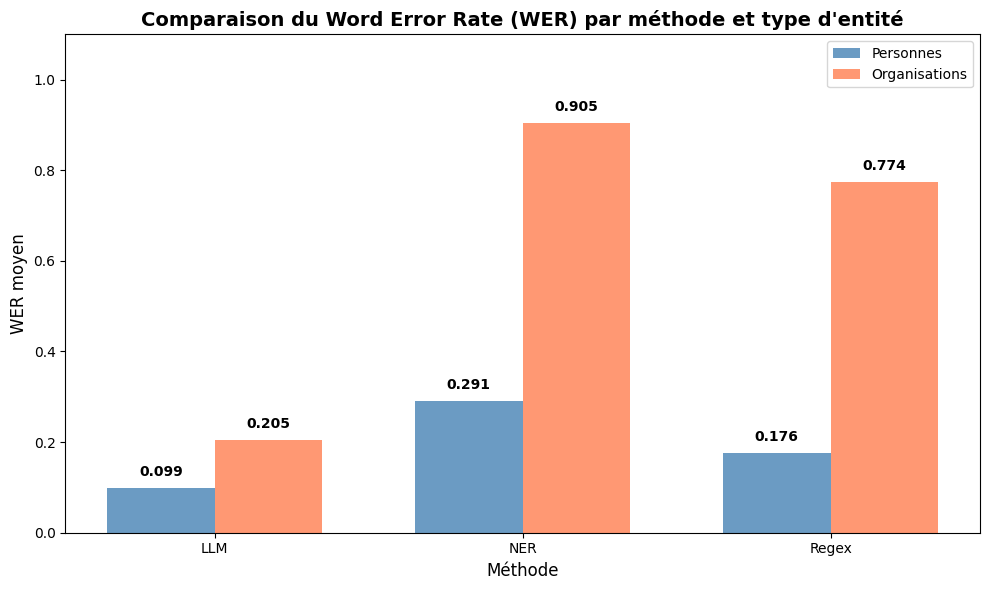

In [18]:
# Fonctions d'extraction
def get_persons(data):
    """Extrait la liste des personnes depuis GT (string) ou prédictions (dict)"""
    if data is None:
        return []
    
    if isinstance(data, dict):
        return data.get("persons", [])
    
    if isinstance(data, str):
        try:
            data_dict = ast.literal_eval(data)
            if isinstance(data_dict, dict):
                return data_dict.get("persons", [])
        except:
            pass
        
        try:
            # Remplacer ' par " pour JSON
            data_json = data.replace("'", '"')
            data_dict = json.loads(data_json)
            if isinstance(data_dict, dict):
                return data_dict.get("persons", [])
        except:
            pass
        
        try:
            data_dict = eval(data)
            if isinstance(data_dict, dict):
                return data_dict.get("persons", [])
        except:
            pass
    
    return []

def get_orgs(data):
    """Extrait la liste des organisations depuis GT (string) ou prédictions (dict)"""
    if data is None:
        return []
    
    if isinstance(data, dict):
        return data.get("organisations", [])
    
    if isinstance(data, str):
        try:
            data_dict = ast.literal_eval(data)
            if isinstance(data_dict, dict):
                return data_dict.get("organisations", [])
        except:
            try:
                data_json = data.replace("'", '"')
                data_dict = json.loads(data_json)
                if isinstance(data_dict, dict):
                    return data_dict.get("organisations", [])
            except:
                try:
                    data_dict = eval(data)
                    if isinstance(data_dict, dict):
                        return data_dict.get("organisations", [])
                except:
                    pass
    
    return []

# Évaluation 
def evaluate_wer(df_pred, df_gt, method_name):
    """
    Calcule WER pour une méthode donnée
    """
    results = []
    
    for i in range(len(df_gt)):
        gt = df_gt.iloc[i]["entities"]
        pred = df_pred.iloc[i]["entities"]
        
        # Personnes
        gt_persons = get_persons(gt)
        pr_persons = get_persons(pred)
        
        for gt_p in gt_persons:
            gt_str = f"{gt_p.get('first_name','')} {gt_p.get('last_name','')}".strip()
            if not gt_str:
                continue
                
            # Chercher la meilleure correspondance (basée sur WER)
            best_wer = float('inf')
            best_pred = ""
            
            for pr_p in pr_persons:
                pr_str = f"{pr_p.get('first_name','')} {pr_p.get('last_name','')}".strip()
                if not pr_str:
                    continue
                try:
                    score = wer(gt_str, pr_str)
                    if score < best_wer:
                        best_wer = score
                        best_pred = pr_str
                except:
                    continue
            
            results.append({
                "Méthode": method_name,
                "Type": "Personne",
                "GT": gt_str,
                "Prédiction": best_pred if best_pred else "(non trouvé)",
                "WER": best_wer if best_pred else 1.0
            })
        
        # Organisations
        gt_orgs = get_orgs(gt)
        pr_orgs = get_orgs(pred)
        
        for gt_o in gt_orgs:
            gt_str = gt_o.get('name', '').strip()
            if not gt_str:
                continue
                
            best_wer = float('inf')
            best_pred = ""
            
            for pr_o in pr_orgs:
                pr_str = pr_o.get('name', '').strip()
                if not pr_str:
                    continue
                try:
                    score = wer(gt_str, pr_str)
                    if score < best_wer:
                        best_wer = score
                        best_pred = pr_str
                except:
                    continue
            
            results.append({
                "Méthode": method_name,
                "Type": "Organisation",
                "GT": gt_str,
                "Prédiction": best_pred if best_pred else "(non trouvé)",
                "WER": best_wer if best_pred else 1.0
            })
    
    return pd.DataFrame(results)


# Tableau comparatif
print("="*80)
print("COMPARAISON DES MÉTHODES D'EXTRACTION D'ENTITÉS (WER)")
print("="*80)

# Calcul pour chaque méthode
df_regex_wer = evaluate_wer(df_regex, df_gt, "Regex")
df_ner_wer = evaluate_wer(df_ner, df_gt, "NER")
df_llm_wer = evaluate_wer(df_llm, df_gt, "LLM")

# Fusion des résultats
all_results = pd.concat([df_regex_wer, df_ner_wer, df_llm_wer], ignore_index=True)

# Tableau récapitulatif par méthode et type
summary = all_results.groupby(['Méthode', 'Type'])['WER'].agg([
    ('Moyenne', 'mean'),
    ('Médiane', 'median'),
    ('Écart-type', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Count', 'count')
]).round(3)

print("\n=== RÉSUMÉ WER PAR MÉTHODE ET TYPE ===\n")
print(summary)

# Moyenne globale par méthode
print("\n=== MOYENNE GLOBALE WER PAR MÉTHODE ===\n")
global_summary = all_results.groupby('Méthode')['WER'].agg([
    ('Moyenne', 'mean'),
    ('Médiane', 'median'),
    ('Écart-type', 'std')
]).round(3)
print(global_summary)

# Visualisation
methods = ['LLM', 'NER', 'Regex']
wer_personne = [
    summary.loc[('LLM', 'Personne'), 'Moyenne'],
    summary.loc[('NER', 'Personne'), 'Moyenne'],
    summary.loc[('Regex', 'Personne'), 'Moyenne']
]
wer_org = [
    summary.loc[('LLM', 'Organisation'), 'Moyenne'],
    summary.loc[('NER', 'Organisation'), 'Moyenne'],
    summary.loc[('Regex', 'Organisation'), 'Moyenne']
]

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, wer_personne, width, label='Personnes', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, wer_org, width, label='Organisations', color='coral', alpha=0.8)

# Ajouter les valeurs sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Méthode', fontsize=12)
ax.set_ylabel('WER moyen', fontsize=12)
ax.set_title('Comparaison du Word Error Rate (WER) par méthode et type d\'entité', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Conclusion pour le projet PRIMA

Au regard des besoins du projet PRIMA — produire des données fiables, homogènes et intégrables dans une infrastructure de recherche — toutes les approches ne présentent pas le même niveau d’adéquation.

Les méthodes par règles sont efficaces pour des cas simples et bien définis, mais leur maintenance devient rapidement coûteuse sur des corpus vastes et hétérogènes.

Le NER généraliste atteint ses limites face aux spécificités des sources patrimoniales : vocabulaire spécialisé, latin, abréviations, structures anciennes. Un post-traitement important reste nécessaire pour atteindre le niveau de qualité attendu.

L’approche par modèle de langage apparaît aujourd’hui comme la plus opérationnelle. Toutefois, malgré ses performances, un LLM demeure difficile à interpréter et peut produire des informations plausibles mais absentes du texte. La dépendance à un service externe soulève également des enjeux de stabilité, de coût et de reproductibilité.

Dans PRIMA, le LLM pourrait donc être envisagé comme un **outil d’assistance** à l’extraction, intégré dans une chaîne incluant contrôle qualité et validation experte.

Il ne remplace pas l’expertise métier, mais réduit fortement l’effort de normalisation préalable et accélère la mise à disposition de données scientifiquement exploitables.